In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [2]:
import tensorflow as tf
print("TensorFlow device:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")


TensorFlow device: CPU


In [3]:
zip_path = "Teeth DataSet.zip"
extract_path = "Teeth DataSet"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)
print("Subfolders:", os.listdir(extract_path))


Extracted to: Teeth DataSet
Subfolders: ['Teeth_Dataset']


In [5]:
DATA_DIR = os.path.join(extract_path, "Teeth_Dataset")
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
VAL_DIR   = os.path.join(DATA_DIR, "Validation")
TEST_DIR  = os.path.join(DATA_DIR, "Testing")
print("Subfolders in data directory:", os.listdir(DATA_DIR))
print("TRAIN_DIR :", os.listdir(TRAIN_DIR))
print("VAL_DIR   :", os.listdir(VAL_DIR))
print("TEST_DIR  :", os.listdir(TEST_DIR))


Subfolders in data directory: ['Testing', 'Training', 'Validation']
TRAIN_DIR : ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
VAL_DIR   : ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
TEST_DIR  : ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 7
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

Found 3087 files belonging to 7 classes.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)


Found 1028 files belonging to 7 classes.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

Found 1028 files belonging to 7 classes.


In [10]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


       CaS  CoS  Gum   MC   OC  OLP   OT
train  480  450  360  540  324  540  393
val    160  149  120  180  108  180  131
test   160  149  120  180  108  180  131


<Figure size 1000x400 with 0 Axes>

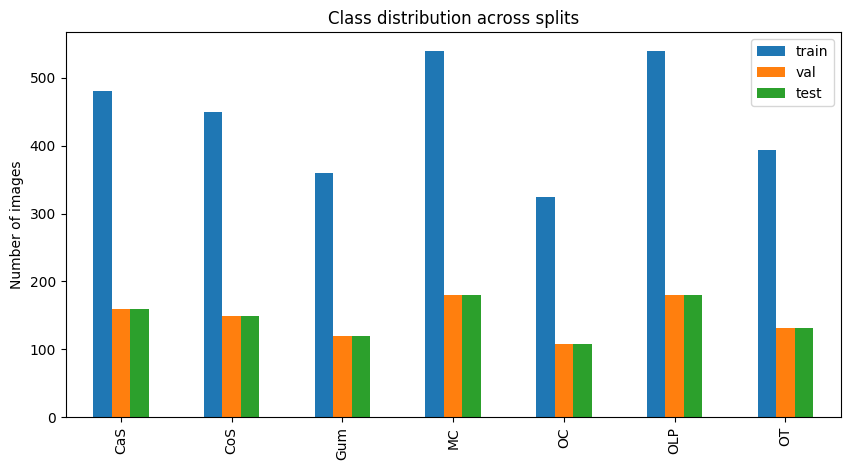

In [11]:
def dataset_class_distribution(ds):
    counts = {c:0 for c in class_names}
    for images, labels in ds.unbatch().map(lambda x,y:(x,y)).batch(10000):
        for l in labels.numpy():
            counts[class_names[int(l)]] += 1
    return counts

train_counts = dataset_class_distribution(train_ds)
val_counts = dataset_class_distribution(val_ds)
test_counts = dataset_class_distribution(test_ds)

dist_df = pd.DataFrame([train_counts, val_counts, test_counts], index=["train","val","test"])
print(dist_df)

plt.figure(figsize=(10,4))
dist_df.T.plot(kind='bar', stacked=False, figsize=(10,5))
plt.title("Class distribution across splits")
plt.ylabel("Number of images")
plt.show()

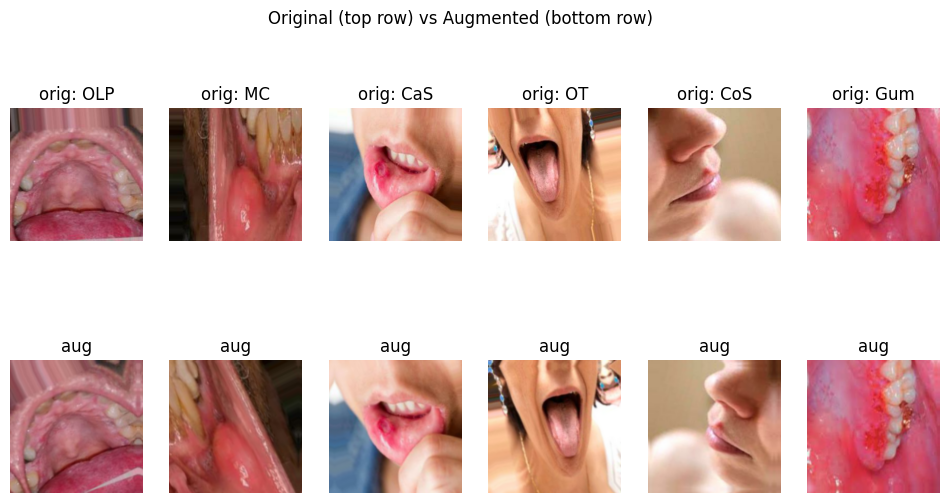

In [12]:
normalization_layer = layers.Rescaling(1./255)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.08),
        layers.RandomTranslation(0.05, 0.05),
    ],
    name="data_augmentation",
)

plt.figure(figsize=(12,6))
for images, labels in train_ds.take(1):
    images = images[:6]
    labels = labels[:6]
    for i in range(6):
        ax = plt.subplot(2,6, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(f"orig: {class_names[labels[i]]}")
        plt.axis("off")

    aug_images = data_augmentation(images)
    for i in range(6):
        ax = plt.subplot(2,6, 6+i+1)
        plt.imshow(aug_images[i].numpy().astype("uint8"))
        ax.set_title("aug")
        plt.axis("off")
plt.suptitle("Original (top row) vs Augmented (bottom row)")
plt.show()

In [13]:
train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x,y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x,y: (normalization_layer(x), y))

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [20]:
def create_model(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(265, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="teeth_cnn")
    return model

model = create_model()
model.summary()

Model: "teeth_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_7 (Batc  (None, 112, 112, 64)     25

In [22]:
#initial_lr = 1e-3
model.compile(
    #optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint_path = "best_teeth_model.h5"
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    #keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks,
    verbose = 1
)

Epoch 1/100
193/193 [==============================] - ETA: 0s - loss: 1.9571 - accuracy: 0.2766
Epoch 1: val_accuracy improved from -inf to 0.21984, saving model to best_teeth_model.h5
193/193 [==============================] - 199s 839ms/step - loss: 1.9571 - accuracy: 0.2766 - val_loss: 2.0938 - val_accuracy: 0.2198
Epoch 2/100
193/193 [==============================] - ETA: 0s - loss: 1.7089 - accuracy: 0.3421
Epoch 2: val_accuracy did not improve from 0.21984
193/193 [==============================] - 194s 821ms/step - loss: 1.7089 - accuracy: 0.3421 - val_loss: 2.2928 - val_accuracy: 0.2179
Epoch 3/100
193/193 [==============================] - ETA: 0s - loss: 1.6127 - accuracy: 0.3858
Epoch 3: val_accuracy improved from 0.21984 to 0.29961, saving model to best_teeth_model.h5
193/193 [==============================] - 194s 822ms/step - loss: 1.6127 - accuracy: 0.3858 - val_loss: 1.8487 - val_accuracy: 0.2996
Epoch 4/100
193/193 [==============================] - ETA: 0s - loss: 1

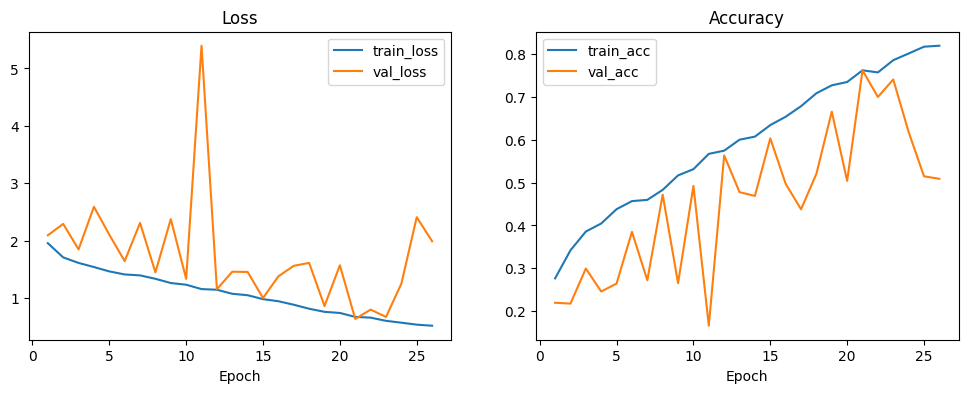

In [24]:
def plot_history(history):
    h = history.history
    epochs = range(1, len(h['loss'])+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(epochs, h['accuracy'], label='train_acc')
    plt.plot(epochs, h['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

plot_history(history)

In [25]:
test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

65/65 [==============================] - 12s 176ms/step - loss: 0.6179 - accuracy: 0.7743
Test accuracy: [0.6179163455963135, 0.774319052696228]


1/1 [==============================] - 0s 79ms/step
Classification Report:
              precision    recall  f1-score   support

         CaS       0.87      0.79      0.83       160
         CoS       0.98      0.76      0.86       149
         Gum       0.78      0.89      0.83       120
          MC       0.67      0.84      0.75       180
          OC       0.77      0.71      0.74       108
         OLP       0.66      0.80      0.73       180
          OT       0.87      0.59      0.70       131

    accuracy                           0.77      1028
   macro avg       0.80      0.77      0.78      1028
weighted avg       0.79      0.77      0.78      1028

Confusion matrix:
 [[127   1   8   8   9   4   3]
 [ 12 113   6   4   3   5   6]
 [  3   0 107   6   0   4   0]
 [  1   1   7 151   6  14   0]
 [  0   0   2  11  77  18   0]
 [  3   0   4  23   3 144   3]
 [  0   0   3  21   2  28  77]]


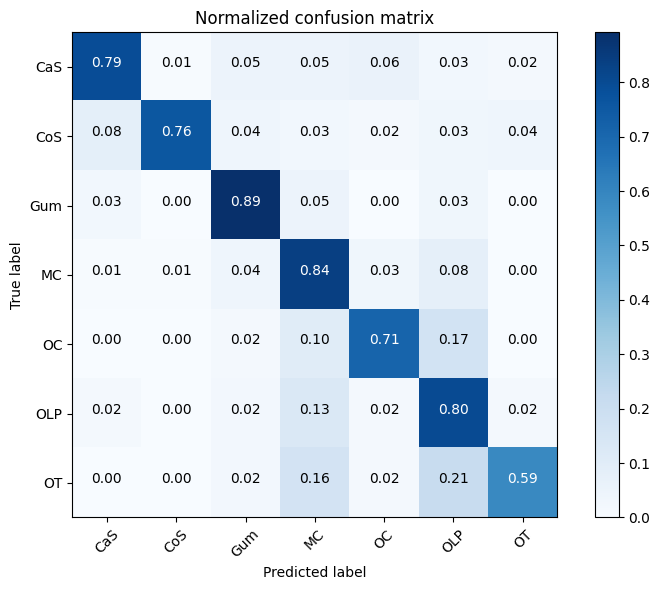

In [26]:
model.load_weights(checkpoint_path)

y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8,6))
    if normalize:
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cmn = cm
    plt.imshow(cmn, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cmn.max() / 2.
    for i, j in itertools.product(range(cmn.shape[0]), range(cmn.shape[1])):
        plt.text(j, i, format(cmn[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cmn[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, class_names, normalize=True, title='Normalized confusion matrix')

In [ ]:
# model.save("teeth_classification_saved_model")

# print("Model and artifacts saved.")